In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.stats import norm,skew

from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin,clone

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/autompg-dataset/auto-mpg.csv


In [2]:
data = pd.read_csv("/kaggle/input/autompg-dataset/auto-mpg.csv")
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
data.drop("car name",inplace=True,axis=1)

In [4]:
data = data.rename(columns = {"mpg":"target"})

In [5]:
data.shape

(398, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 25.0+ KB


In [7]:
data['horsepower']=data['horsepower'].replace('?','150')
data['horsepower']=data['horsepower'].astype('int')
'?' in data['horsepower']

False

In [8]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
target,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
horsepower,398.0,105.155779,38.600986,46.0,76.000,95.0,130.000,230.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [9]:
data.isnull().sum()

target          0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64

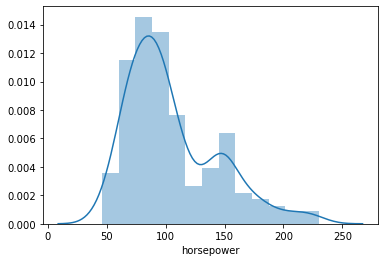

In [10]:
sns.distplot(data.horsepower);

### *Exploratory Data Analysis (EDA)*

In [11]:
data_corr = data.corr()

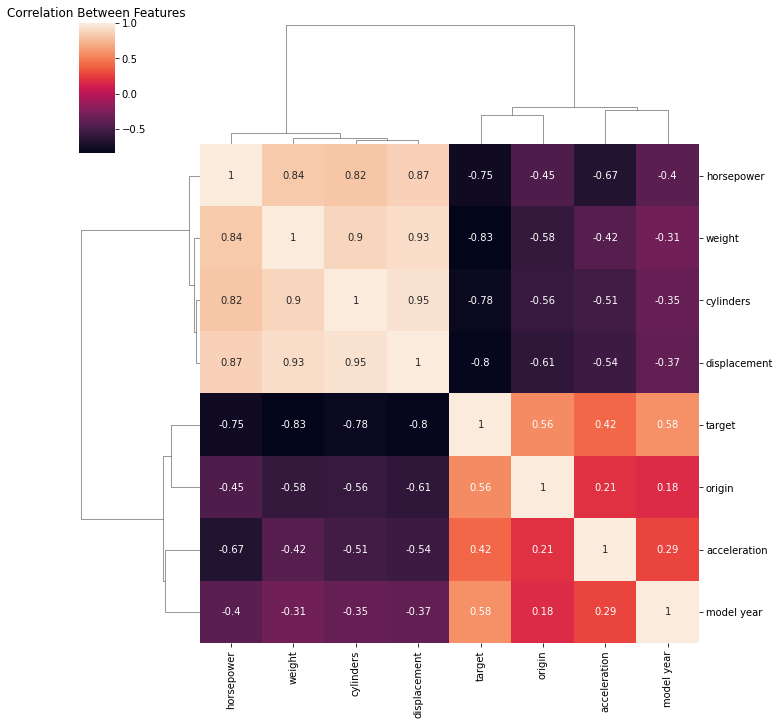

In [12]:
sns.clustermap(data_corr,annot=True);
plt.title("Correlation Between Features");
plt.show();

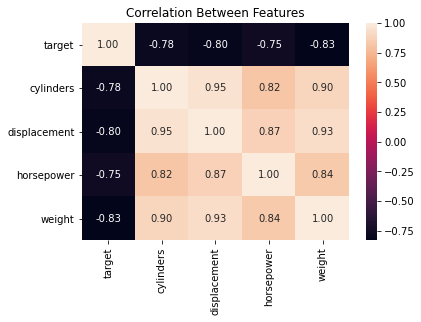

In [13]:
threshold = 0.75
filter_ = np.abs(data_corr["target"]) > threshold
corr_features = data_corr.columns[filter_].tolist()

sns.heatmap(data[corr_features].corr(),annot=True,fmt=".2f");
plt.title("Correlation Between Features");
plt.show();

In [14]:
# result: multicollinearity

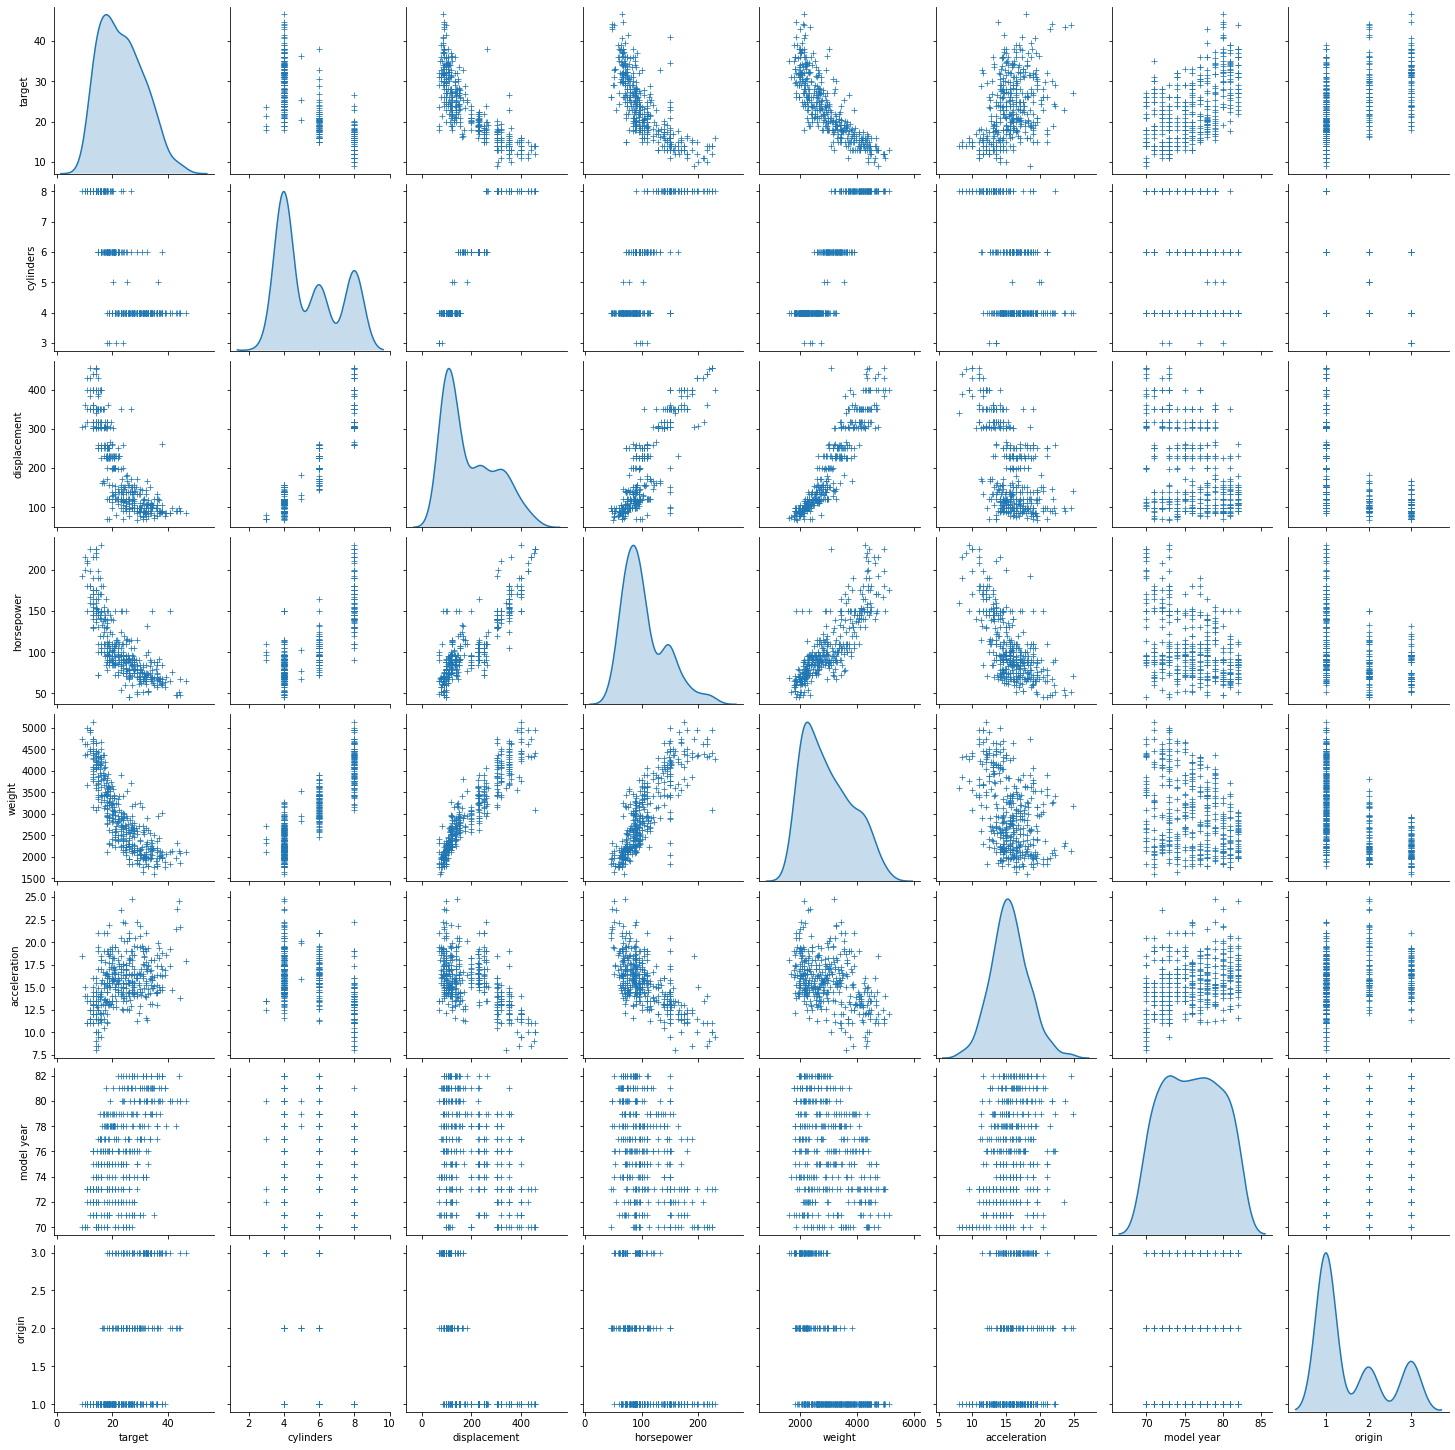

In [15]:
sns.pairplot(data,diag_kind="kde",markers="+");
plt.show();

In [16]:
#cylinders and origin can be categorical

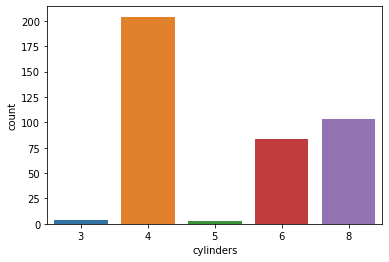

In [17]:
plt.figure();
sns.countplot(data["cylinders"]);

In [18]:
print(data["cylinders"].value_counts());

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64


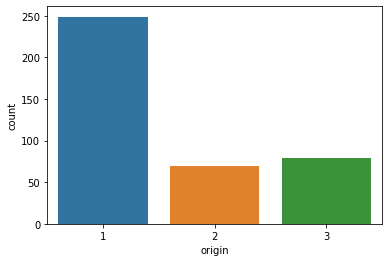

In [19]:
plt.figure();
sns.countplot(data["origin"]);

In [20]:
print(data["origin"].value_counts())

1    249
3     79
2     70
Name: origin, dtype: int64


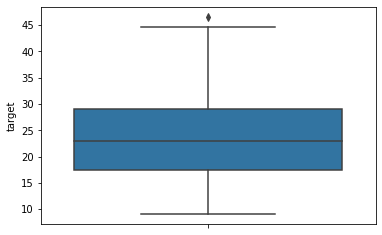

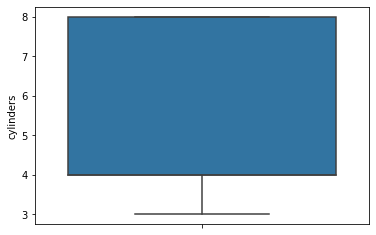

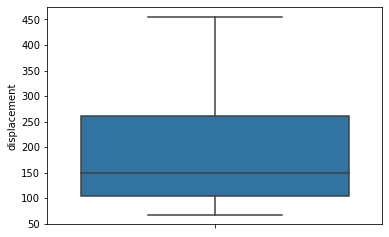

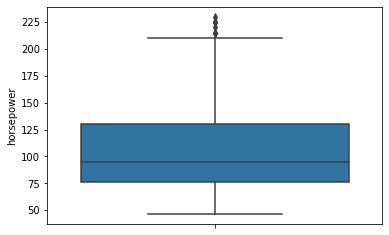

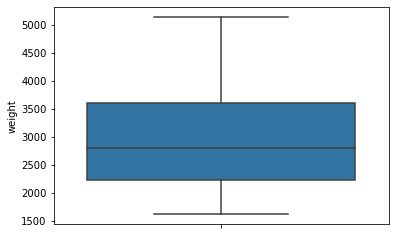

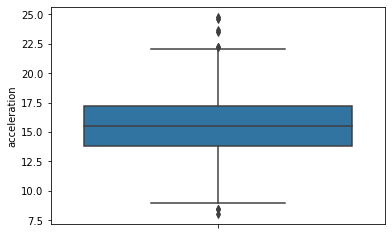

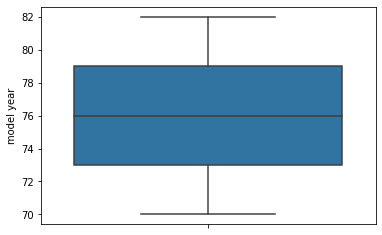

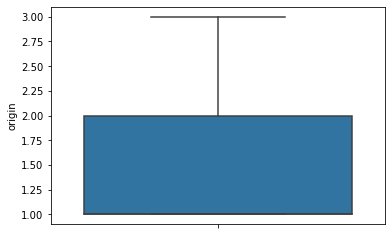

In [21]:
for i in data.columns:
    plt.figure();
    sns.boxplot(x=i,data=data,orient="v")

### *Outlier Detection*

*Horsepower*

In [22]:
th = 2

Q1_hp = data.horsepower.quantile(0.25)
Q3_hp = data.horsepower.quantile(0.75)
IQR_hp = Q3_hp - Q1_hp
print(IQR_hp)

top_limit_hp = Q3_hp + th * IQR_hp
top_limit_hp

bottom_limit_hp = Q1_hp - th * IQR_hp
bottom_limit_hp

filter_hp_bottom = bottom_limit_hp < data.horsepower
filter_hp_top = data.horsepower < top_limit_hp
filter_hp = filter_hp_bottom & filter_hp_top

data = data[filter_hp]
data.shape

54.0


(398, 8)

*Acceleration*

In [23]:
th = 2

Q1_ac = data.acceleration.quantile(0.25)
Q3_ac = data.acceleration.quantile(0.75)
IQR_ac = Q3_ac - Q1_ac
print(IQR_ac)

top_limit_ac = Q3_ac + th * IQR_ac
top_limit_ac
bottom_limit_ac = Q1_ac - th * IQR_ac
bottom_limit_ac

filter_ac_bottom = bottom_limit_ac < data.acceleration
filter_ac_top = data.acceleration < top_limit_ac
filter_ac = filter_ac_bottom & filter_ac_top

data = data[filter_ac]
data.shape

3.349999999999996


(396, 8)

### *Feature Engineering*

***Skewness***

In [24]:
# target - dependent variable

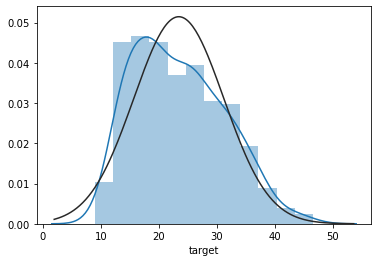

In [25]:
sns.distplot(data.target,fit=norm);

In [26]:
(mu,sigma) = norm.fit(data["target"])
print("mu: {}, sigma: {}".format(mu,sigma))

mu: 23.45353535353535, sigma: 7.755393211495581


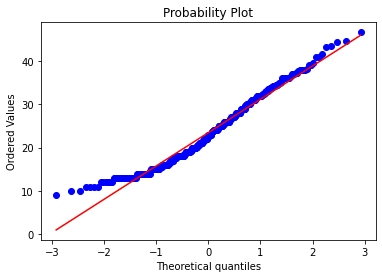

In [27]:
# qq plot
plt.figure();
stats.probplot(data["target"],plot = plt);
plt.show();

In [28]:
data["target"] = np.log1p(data["target"])

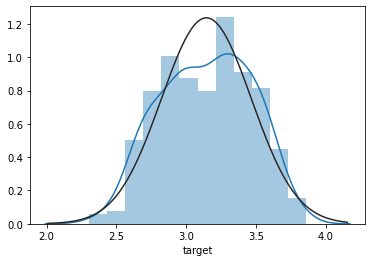

In [29]:
plt.figure();
sns.distplot(data.target,fit=norm);

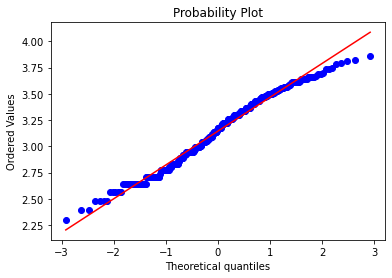

In [30]:
# qq plot
plt.figure();
stats.probplot(data["target"],plot = plt);
plt.show();

In [31]:
# feature - independent variable
skewed_features = data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)

In [32]:
skewness = pd.DataFrame(skewed_features,columns=["skewed"])
skewness

,skewed
horsepower,1.028272
origin,0.927260
displacement,0.709647
weight,0.526706
cylinders,0.516734
acceleration,0.154261
model year,0.017882
target,-0.112372


***One Hot Encoding***

In [33]:
# cylinders & origin

In [34]:
data["cylinders"] = data["cylinders"].astype(str) 
data["origin"] = data["origin"].astype(str) 

In [35]:
data = pd.get_dummies(data)

In [36]:
data.head()

,target,displacement,horsepower,weight,acceleration,model year,cylinders_3,cylinders_4,cylinders_5,cylinders_6,cylinders_8,origin_1,origin_2,origin_3
0,2.944439,307.0,130,3504,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165,3693,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150,3436,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150,3433,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140,3449,10.5,70,0,0,0,0,1,1,0,0


### *Train Test Split & Standardization*

**Split**

In [37]:
x = data.drop(["target"],axis=1)
y = data.target

In [38]:
test_size = 0.9
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=test_size,random_state=42)

**Standardization**

In [39]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

### *Linear Regression*

In [40]:
lr = LinearRegression()
lr.fit(x_train,y_train)
print("LR Coef: ", lr.coef_)
y_pred = lr.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("LR MSE: ",mse)

LR Coef:  [-1.94099588e-01 -5.94210884e-02 -9.80161059e-02 -1.40897730e-02
  7.87796027e-02 -5.87807605e-02 -3.11216037e-02 -1.38777878e-17
  6.09318617e-03  5.77344983e-02  3.98991435e-04  1.29341190e-02
 -1.39855962e-02]
LR MSE:  0.02281172799933069


### *Regularization : Ridge Regression (L2)*

In [41]:
ridge = Ridge(random_state=42,max_iter=10000)
alphas = np.logspace(-4,-0.5,30)
tuned_params = [{'alpha':alphas}]
n_folds = 5

clf = GridSearchCV(ridge,tuned_params, cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(x_train,y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ", clf.best_estimator_.coef_)
ridge = clf.best_estimator_

print("Ridge Best Estimator: ",ridge)
y_pred = clf.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("Ridge MSE: ",mse)

Ridge Coef:  [-0.15308925 -0.06685659 -0.09901843 -0.01283961  0.07947601 -0.05032802
 -0.01686738  0.          0.00132374  0.04107078 -0.00269854  0.01534258
 -0.01269474]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.021114200897180857


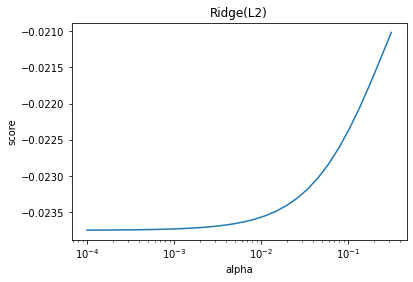

In [42]:
plt.figure();
plt.semilogx(alphas,scores);
plt.xlabel("alpha");
plt.ylabel("score");
plt.title("Ridge(L2)");

### *Regularization : Lasso Regression (L1)*

In [43]:
lasso = Lasso(random_state=42,max_iter=10000)
alphas = np.logspace(-4,-0.5,30)
tuned_params = [{'alpha':alphas}]
n_folds = 5

clf = GridSearchCV(lasso,tuned_params, cv=n_folds,scoring="neg_mean_squared_error",refit=True)
clf.fit(x_train,y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Lasso Coef: ", clf.best_estimator_.coef_)
lasso = clf.best_estimator_

print("Lasso Best Estimator: ",lasso)
y_pred = clf.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("Lasso MSE: ",mse)

Lasso Coef:  [-0.05600548 -0.06431834 -0.1015567   0.          0.07051264 -0.0163602
  0.02641842  0.         -0.         -0.         -0.          0.01787513
 -0.        ]
Lasso Best Estimator:  Lasso(alpha=0.014873521072935119, max_iter=10000, random_state=42)
Lasso MSE:  0.016898274596698733


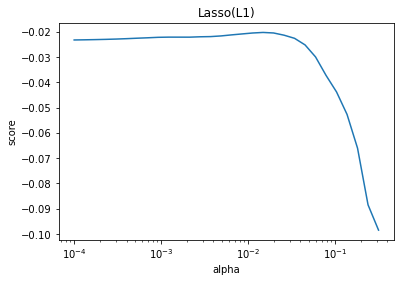

In [44]:
plt.figure();
plt.semilogx(alphas,scores);
plt.xlabel("alpha");
plt.ylabel("score");
plt.title("Lasso(L1)");

### *Regularization : ElasticNet*

In [45]:
parametersGrid = {"alpha": alphas,
                  "l1_ratio": np.arange(0.0, 1.0, 0.05)}

eNet = ElasticNet(random_state=42, max_iter=10000)
clf = GridSearchCV(eNet, parametersGrid, cv=n_folds, scoring='neg_mean_squared_error', refit=True)
clf.fit(x_train, y_train)


print("ElasticNet Coef: ",clf.best_estimator_.coef_)
print("ElasticNet Best Estimator: ",clf.best_estimator_)


y_pred = clf.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("ElasticNet MSE: ",mse)

ElasticNet Coef:  [-0.06156329 -0.06974385 -0.08077833 -0.          0.06662172 -0.0168775
  0.03623879  0.         -0.         -0.         -0.          0.01931267
 -0.        ]
ElasticNet Best Estimator:  ElasticNet(alpha=0.10404983103657853, l1_ratio=0.1, max_iter=10000,
           random_state=42)
ElasticNet MSE:  0.017530265653211696


* Linear Regression MSE: 0.02281172799933069
* Ridge MSE: 0.021114200897180854
* Lasso MSE: 0.016898274596698744
* ElasticNet MSE: 0.017530265653211696

### *XGBoost*

In [46]:
parametersGrid = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [.03, 0.05, .07], 
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500,1000]}

model_xgb = xgb.XGBRegressor()

clf = GridSearchCV(model_xgb, parametersGrid, cv = n_folds, scoring='neg_mean_squared_error', refit=True, n_jobs = 5, verbose=True)

clf.fit(x_train, y_train)
model_xgb = clf.best_estimator_

y_pred = clf.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("XGBRegressor MSE: ",mse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   37.3s
[Parallel(n_jobs=5)]: Done  90 out of  90 | elapsed:  1.4min finished


XGBRegressor MSE:  0.016744752937642743


### *Averaging Models*

In [47]:
class AveragingModels():
    def __init__(self,models):
        self.models = models
    
    def fit(self,x,y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(x,y)   
        return self
    
    def predict(self,x):
        predictions = np.column_stack([model.predict(x) for model in self.models_])
        return np.mean(predictions,axis=1)

In [48]:
averaged_models = AveragingModels(models = (model_xgb, lasso))
averaged_models.fit(x_train, y_train)

In [49]:
y_pred = averaged_models.predict(x_test)
mse = mean_squared_error(y_test,y_pred)
print("Averaged Models MSE: ",mse)

Averaged Models MSE:  0.014218076665206747
